## Analysis of how the device efficiency impact the number of citations

In [3]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression

Data for perovskite devices are downloaded from the Perovskite Database Project in December 2021. <br>
The highest efficiency for each paper was extracted, and the corresponding citation data was downloaded from Crossref on 2022-03-06 <br>

In [4]:
# File paths
fileName_data = 'Citation_data.csv'
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "data")
path_data = os.path.join(path_data_folder, fileName_data)
path_figure_folder = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), "Figures")

#### Helper functions

In [5]:
def generate_time_bins(data, start, interval, periods):
    """data is a pandas series. return a pandas series binned with a start date and period numbers of intervals with length intervals"""
    bins_dt = pd.date_range(start, freq=interval, periods=periods)
    bins_str = bins_dt.astype(str).values
    if interval == "1Y":
        date_labels = [x[0:4] for x in bins_str[0:-1]]
        date_labels = [str(int(x) + 1) for x in date_labels] # Compensate for that year string starts on last of december
    else:
        date_labels = ['({}, {}]'.format(bins_str[i - 1], bins_str[i]) for i in range(1, len(bins_str))]
    return pd.cut(data.astype(np.int64) // 10**9,
                              bins=bins_dt.astype(np.int64) // 10**9,
                              labels=date_labels)

def save_figure(path_figure_folder, fileName, fig):
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.tif')), dpi=300, format='tif')
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.png')), dpi=300, format='png')
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.pdf')), dpi=300, format='pdf')

#### Data treatment

In [6]:
# Read in data
citation_data = pd.read_csv(path_data)

# Convert data strings to time stamps
citation_data['Date'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in citation_data['Ref_publication_date']]

# Bin the data with respect to publication time in 6M periods
citation_data["date_bins_half_year"] = generate_time_bins(data=citation_data["Date"], 
                                                          start="2011-06-01", 
                                                          interval="6M", 
                                                          periods=20)

# Bin the data with respect to publication time for hole years
citation_data["date_bins_years"] = generate_time_bins(data=citation_data["Date"], 
                                                          start="2010-01-01", 
                                                          interval="1Y", 
                                                          periods=13)

# Bin the data with respect to PCE
start = 0
end = 26
delta = 1
antal = int(round((end-start)/delta)) + 1
cut_bins = np.linspace(start, end, antal)
pce_cut_labels = np.linspace(start + delta / 2, end + delta / 2, antal)[:-1]
citation_data['PCE_bins'] = pd.cut(citation_data['JV_default_PCE'], bins=cut_bins, labels=pce_cut_labels)

# Logarithm of citation data. To prevent infinite values minimum citation rate is set to zero
citations = citation_data['Citations'].replace(0, 1, inplace=False)
citation_data['log_citations'] = np.log10(citations)

#### Analysis and plotting

Text(0.5, 0, 'Publication date')

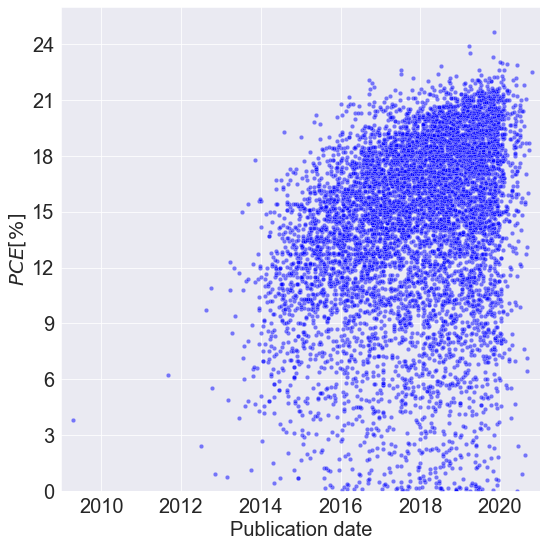

In [8]:
# Initial scatterplot
sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)  # Set up a figure

# Scatterplot
ax = sns.scatterplot(data=citation_data,
                        x="Date",
                        y="JV_default_PCE",
                        color="blue",
                        alpha=0.5,
                        s=20)

ax.set_yticks(np.arange(0, 26, step=3))
ax.set_ylabel(r"$PCE [\%]$")
ax.set_ylim(0, 26)

ax.xaxis_date()
ax.set_xticks(
    [datetime.date(2010, 1, 1), datetime.date(2012, 1, 1), datetime.date(2014, 1, 1), datetime.date(2016, 1, 1),
        datetime.date(2018, 1, 1), datetime.date(2020, 1, 1)])
ax.xaxis.major.formatter.scaled[1.0] = "%Y"
ax.set_xlim(datetime.date(2009, 1, 1), datetime.date(2021, 1, 1))
ax.set_xlabel(r"Publication date")


# fileName = 'PCE_vs_publication_year_scatter'
# save_figure(path_figure_folder, fileName, fig)

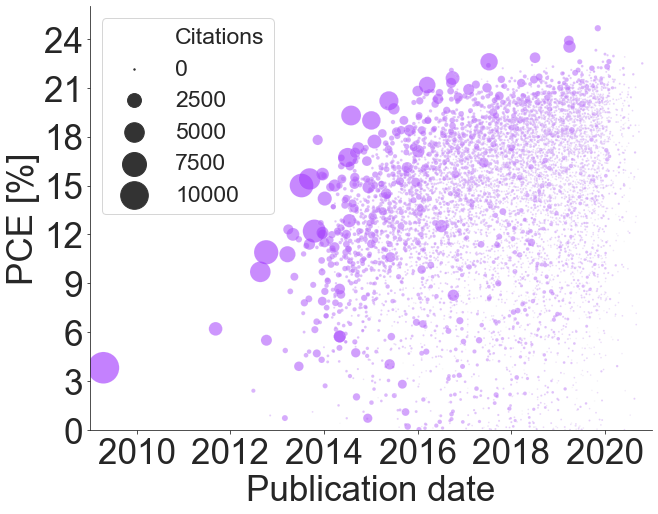

In [9]:
# Generate a bubble plot
# sns.set_style("darkgrid")  # Set the graphical theme
sns.set_style("ticks")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)  # Set up a figure

ax = sns.scatterplot(data=citation_data,
                        x="Date",
                        y="JV_default_PCE",
                        size="Citations",
                        # color="#9D2EFE",
                        # hue="Citations",
                        hue="log_citations",
                        palette=sns.light_palette("#9D2EFE", as_cmap=True),
                        # palette=sns.light_palette("#08316D", as_cmap=True),
                        sizes=(2, 1000),
                        alpha=0.6, )

ax.set_yticks(np.arange(0, 26, step=3))
ax.set_ylabel("PCE [%]")
ax.set_ylim(0, 26)

ax.xaxis_date()
ax.set_xticks(
    [datetime.date(2010, 1, 1), datetime.date(2012, 1, 1), datetime.date(2014, 1, 1), datetime.date(2016, 1, 1),
        datetime.date(2018, 1, 1), datetime.date(2020, 1, 1)])
ax.xaxis.major.formatter.scaled[1.0] = "%Y"
ax.set_xlim(datetime.date(2009, 1, 1), datetime.date(2021, 1, 1))
ax.set_xlabel("Publication date")

h, l = ax.get_legend_handles_labels()
ax.legend(h[7:-1], l[7:-1], prop={"size": 23})
# ax.legend( prop={"size": 15})

sns.despine(fig)

# fileName = 'PCE_vs_publication_year_citation_bubble'
# save_figure(path_figure_folder, fileName, fig)

Text(0.5, 1.0, 'Full dataset')

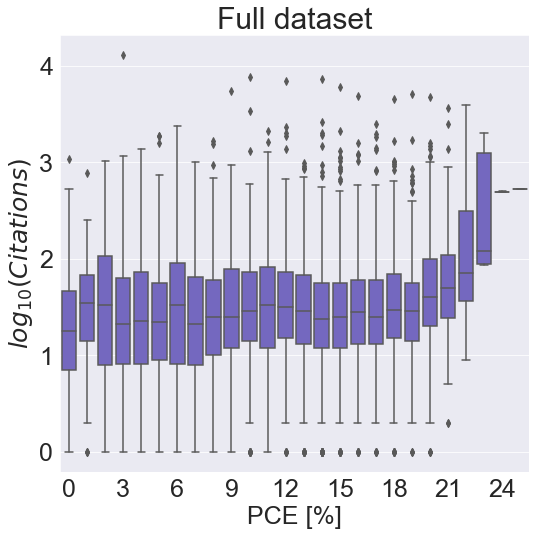

In [10]:
# Histogram Citation vs PCE for compleat dataset
sns.set_style("darkgrid") # Set the graphical theme
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True) # Set up a figure

ax = sns.boxplot(data=citation_data,
                    x="PCE_bins",
                    y="log_citations",
                    color="slateblue")

ax_labels = [a.get_text() for a in ax.get_xticklabels()]
ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
ax_labels_new = ["" for x in ax_labels]
ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
ax.set(xticklabels=ax_labels_new)

# ax.set_yticks(np.arange(0, 4, step = 0.5))
# ax.set_ylim(0.6, 1.4)
ax.set_ylabel("$log_{10}(Citations)$")
ax.set_xlabel("PCE [%]")
ax.set_title("Full dataset")


# fileName = 'Citations_vs_pce_compleat_dataset'
# save_figure(path_figure_folder, fileName, fig)

c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


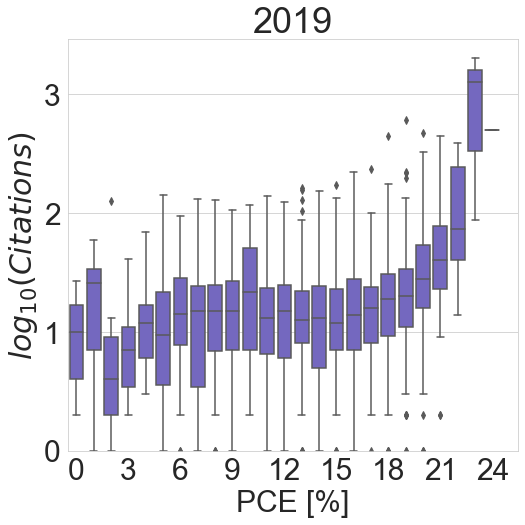

In [14]:
# Histogram Citation vs PCE per year
year = "2019"
col1 = "slateblue"

data_year = citation_data[citation_data["date_bins_years"] == year]

sns.set_style("whitegrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)  # Set up a figure


sns.boxplot(data=data_year,
                    x="PCE_bins",
                    y="log_citations",
                    color=col1,
                    ax=ax)

ax_labels = [a.get_text() for a in ax.get_xticklabels()]
ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
ax_labels_new = ["" for x in ax_labels]
ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
ax.set(xticklabels=ax_labels_new)

# ax.set_yticks(np.arange(0, 4, step = 0.5))
ax.set_ylim(ymin=0)
ax.set_ylabel("$log_{10}(Citations)$")
ax.set_xlabel("PCE [%]")
ax.set_title(f"{year}")

fileName = 'citations_vs_pce_boxplot_years_2019'
save_figure(path_figure_folder, fileName, fig)

c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\admin\anaconda3\envs\PCE_vs_citaton_code\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users

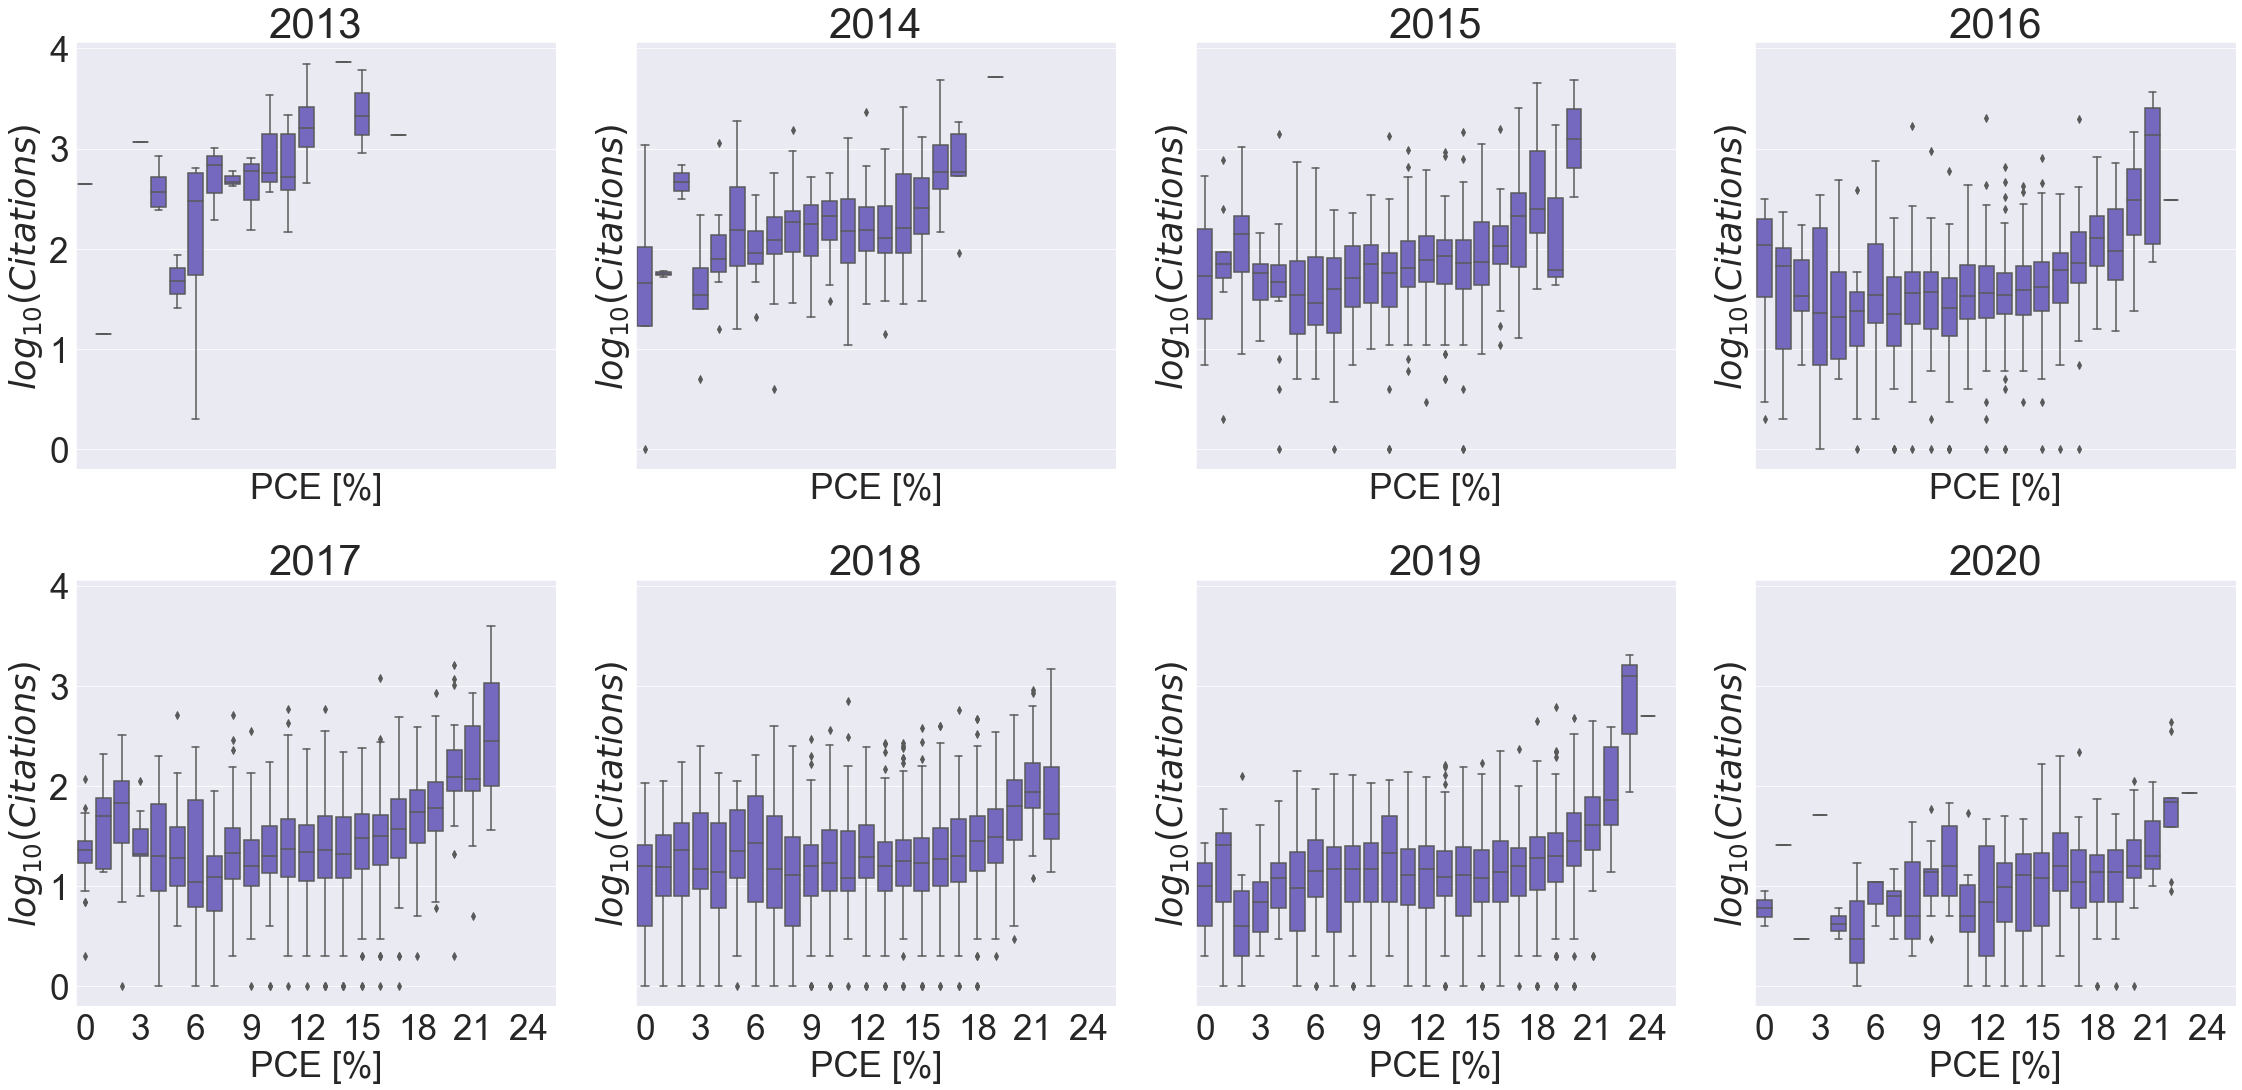

In [19]:
# Histogram Citation vs PCE per year
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
col1 = "slateblue"

# Set up figure
sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    data_year = citation_data[citation_data["date_bins_years"] == year]

    line = sns.boxplot(data=data_year,
                x="PCE_bins",
                y="log_citations",
                color=col1,
                ax=axs_flatten[i])

    ax_labels = [a.get_text() for a in axs_flatten[i].get_xticklabels()]
    ax_labels = [str(int(float(x) - 0.5)) for x in ax_labels]
    ax_labels_new = ["" for x in ax_labels]
    ax_labels_new[0:-1:3] = ax_labels[0:-1:3]
    axs_flatten[i].set(xticklabels=ax_labels_new)

    # ax.set_yticks(np.arange(0, 4, step = 0.5))
    ax.set_ylim(ymin=0)
    axs_flatten[i].set_ylabel("$log_{10}(Citations)$")
    axs_flatten[i].set_xlabel("PCE [%]")
    axs_flatten[i].set_title(f"{year}")


fileName = 'citations_vs_pce_boxplot_years'
save_figure(path_figure_folder, fileName, fig)

Text(0.5, 29.484385627530344, 'Publication date')

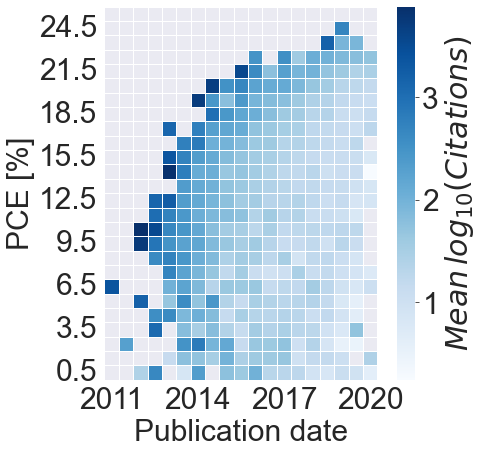

In [23]:
# PCE vs year heatmap

date_labels = sorted(citation_data["date_bins_half_year"].unique().dropna())
# pce_cut_labels = sorted(citation_data["PCE_bins"].unique().dropna())
pce_cut_labels = list(citation_data.groupby(["PCE_bins"]).mean().index)

mean_citaions = {}
for date_label in date_labels:
    temp = citation_data[citation_data["date_bins_half_year"] == date_label]
    mean_citaions[date_label] = temp.groupby(["PCE_bins"]).mean()["log_citations"].values

mean_citaions_df = pd.DataFrame(mean_citaions, index=pce_cut_labels)

sns.set_style("darkgrid") # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 7), tight_layout=True) # Set up a figure
sns.heatmap(mean_citaions_df,
                    annot=False,
                    fmt=".2f",
                    linewidths=0.5,
                    square=True,
                    # cmap="YlOrBr",
                    cmap='Blues',
                    # cmap=sns.light_palette("#9D2EFE", as_cmap=True),
                    # cmap=sns.light_palette("#541690", as_cmap=True),
                    ax=ax,
                    cbar_kws={'label': '$Mean\/log_{10}(Citations)$'})

ax_labels = [a.get_text() for a in ax.get_xticklabels()]
ax_labels = [x[1:5] for x in ax_labels]
ax_labels_new = ["" for x in ax_labels]
ax_labels_new[0::3] = ax_labels[0::3]
ax.set(xticklabels=ax_labels_new)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.invert_yaxis()

ax.set_ylabel("PCE [%]")
ax.set_xlabel("Publication date")

# fileName = 'PCE_year_logCitation_heatmap'
# save_figure(path_figure_folder, fileName, fig)

Text(0.5, 29.484385627530344, 'Publication date')

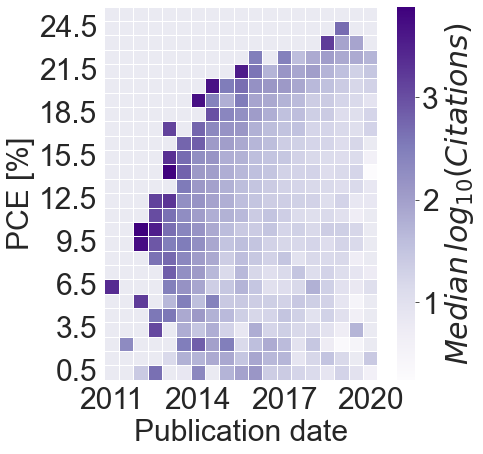

In [24]:
# %% PCE vs year median heatmap
date_labels = sorted(citation_data["date_bins_half_year"].unique().dropna())
# pce_cut_labels = sorted(citation_data["PCE_bins"].unique().dropna())
pce_cut_labels = list(citation_data.groupby(["PCE_bins"]).mean().index)

mean_citaions = {}
for date_label in date_labels:
    temp = citation_data[citation_data["date_bins_half_year"] == date_label]
    mean_citaions[date_label] = temp.groupby(["PCE_bins"]).median()["log_citations"].values

mean_citaions_df = pd.DataFrame(mean_citaions, index=pce_cut_labels)

sns.set_style("darkgrid") # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 7), tight_layout=True) # Set up a figure
sns.heatmap(mean_citaions_df,
                    annot=False,
                    fmt=".2f",
                    linewidths=0.5,
                    square=True,
                    # cmap="YlOrBr",
                    cmap='Purples',
                    # cmap=sns.light_palette("#9D2EFE", as_cmap=True),
                    # cmap=sns.light_palette("#541690", as_cmap=True),
                    ax=ax,
                    cbar_kws={'label': '$Median\/log_{10}(Citations)$'})

ax_labels = [a.get_text() for a in ax.get_xticklabels()]
ax_labels = [x[1:5] for x in ax_labels]
ax_labels_new = ["" for x in ax_labels]
ax_labels_new[0::3] = ax_labels[0::3]
ax.set(xticklabels=ax_labels_new)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.invert_yaxis()

ax.set_ylabel("PCE [%]")
ax.set_xlabel("Publication date")

# fileName = 'PCE_year_logCitation_median_heatmap'
# save_figure(path_figure_folder, fileName, fig)

Text(0.5, 29.484385627530344, 'Publication date')

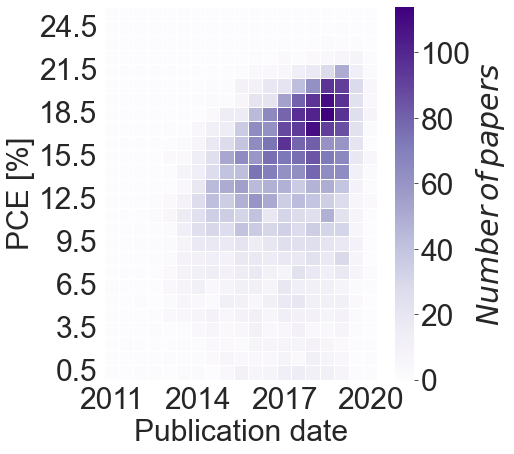

In [31]:
# PCE vs number of papers per year heatmap
date_labels = sorted(citation_data["date_bins_half_year"].unique().dropna())
pce_cut_labels = list(citation_data.groupby(["PCE_bins"]).mean().index)

mean_citaions = {}
for date_label in date_labels:
    temp = citation_data[citation_data["date_bins_half_year"] == date_label]
    mean_citaions[date_label] = temp.groupby(["PCE_bins"]).size().values

mean_citaions_df = pd.DataFrame(mean_citaions, index = pce_cut_labels)

sns.set_style("darkgrid") # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(8, 7), tight_layout=True) # Set up a figure
sns.heatmap(mean_citaions_df,
                    annot=False,
                    fmt=".2f",
                    linewidths=0.5,
                    square=True,
                    # cmap="YlOrBr",
                    cmap='Purples',
                    ax=ax,
                    cbar_kws={'label': '$Number\/of\/papers$'})

ax_labels = [a.get_text() for a in ax.get_xticklabels()]
ax_labels = [x[1:5] for x in ax_labels]
ax_labels_new = ["" for x in ax_labels]
ax_labels_new[0::3] = ax_labels[0::3]
ax.set(xticklabels=ax_labels_new)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.invert_yaxis()

ax.set_ylabel("PCE [%]")
ax.set_xlabel("Publication date")

# fileName = 'PCE_year_number_of_papers_heatmap'
# save_figure(path_figure_folder, fileName, fig)

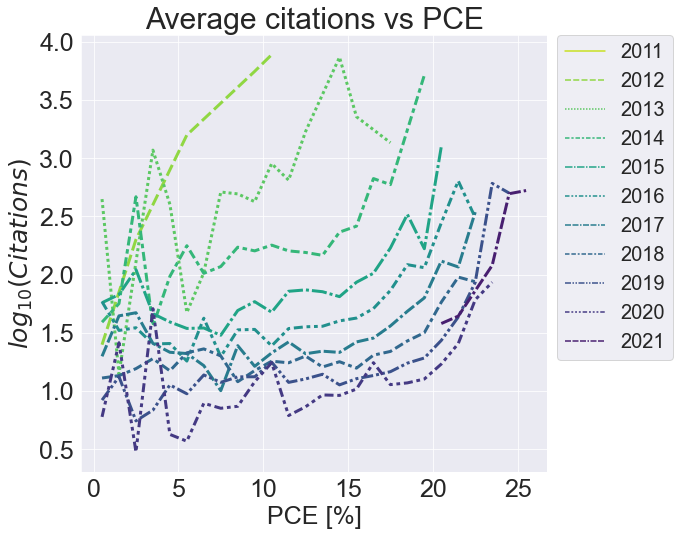

In [68]:
# %% Citation vs PCE line plot
date_labels_years = sorted(citation_data["date_bins_years"].unique().dropna())
pce_cut_labels = list(citation_data.groupby(["PCE_bins"]).mean().index)

mean_citaions = {}
for date_label in date_labels_years:
    temp = citation_data[citation_data["date_bins_years"] == date_label]
    mean_citaions[date_label] = temp.groupby(["PCE_bins"]).mean()["log_citations"].values
mean_citaions_df = pd.DataFrame(mean_citaions, index=pce_cut_labels)

sns.set_style("darkgrid") # Set the graphical theme
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True) # Set up a figure

ax = sns.lineplot(data=mean_citaions_df,
                    palette="viridis_r",
                    lw=3,
                    )
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={"size": 20})

ax.set_ylabel("$log_{10}(Citations)$")
ax.set_xlabel("PCE [%]")

ax.set_title("Average citations vs PCE")

# fileName = 'citations_vs_pce_line_plot_average'
# save_figure(path_figure_folder, fileName, fig)

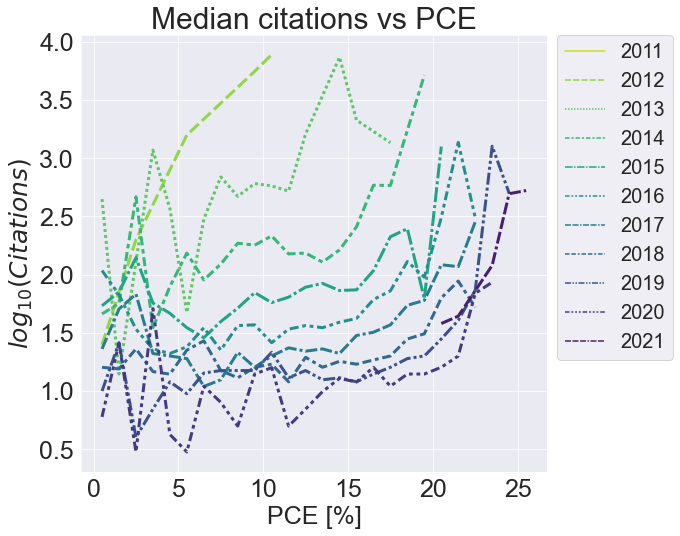

In [36]:
# %% Citation vs PCE line plot median
date_labels_years = sorted(citation_data["date_bins_years"].unique().dropna())
pce_cut_labels = sorted(citation_data["PCE_bins"].unique().dropna())

mean_citaions = {}
for date_label in date_labels_years:
    temp = citation_data[citation_data["date_bins_years"] == date_label]
    mean_citaions[date_label] = temp.groupby(["PCE_bins"]).median()["log_citations"].values
mean_citaions_df = pd.DataFrame(mean_citaions, index=pce_cut_labels)

sns.set_style("darkgrid") # Set the graphical theme
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True) # Set up a figure

sns.lineplot(data=mean_citaions_df,
                    palette="viridis_r",
                    lw=3,
                    ax=ax
                    )
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={"size": 20})

ax.set_ylabel("$log_{10}(Citations)$")
ax.set_xlabel("PCE [%]")

ax.set_title("Median citations vs PCE")

# fileName = 'citations_vs_pce_line_plot'
# save_figure(path_figure_folder, fileName, fig)

Text(0.5, 0, 'Publication date')

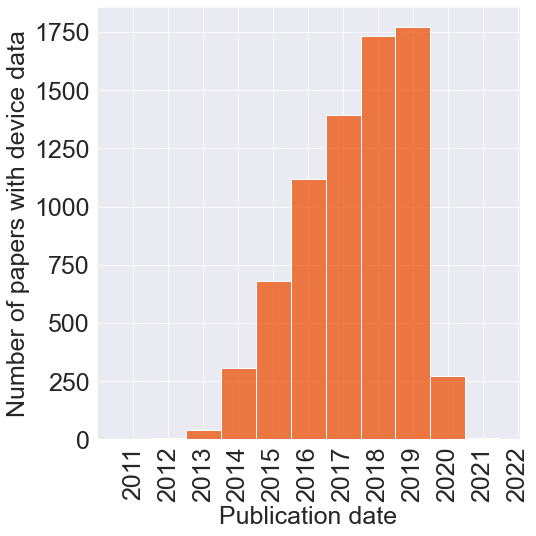

In [38]:
# Number of papers per year
sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)  # Set up a figure

sns.histplot(data=citation_data, x="date_bins_years", color="#EE5007", ax=ax)
plt.xticks(rotation=90)

ax.set_ylabel("Number of papers with device data")
ax.set_xlabel("Publication date")

# fileName = 'number_of_papes_with_devcie_data'
# save_figure(path_figure_folder, fileName, fig)

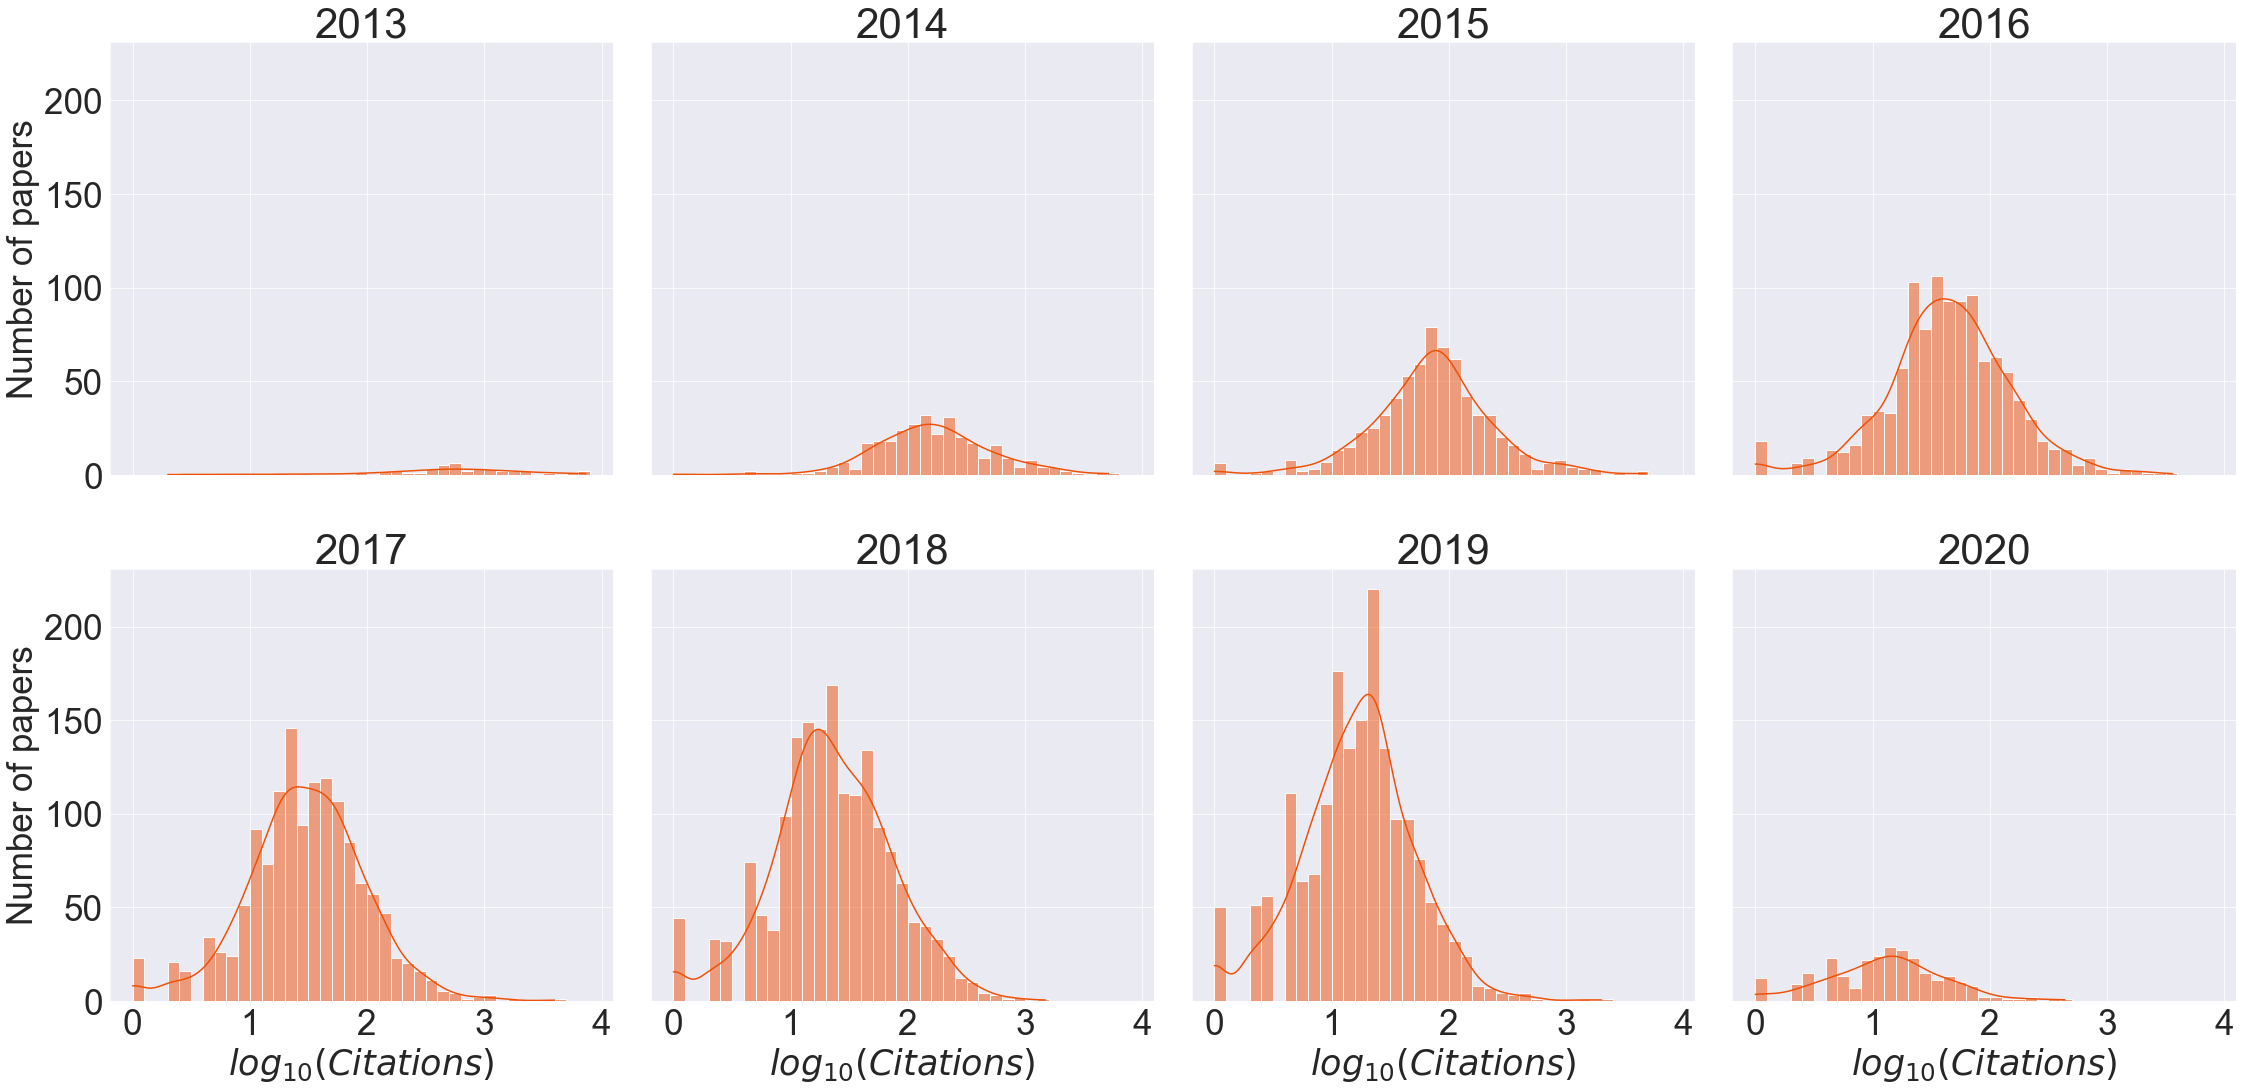

In [41]:
# Histograms number of citations per year
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

sns.set_style("darkgrid") # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):
    sns.histplot(data=citation_data[citation_data["date_bins_years"] == year],
                    x="log_citations",
                    color="#EE5007",
                    kde=True,
                    binwidth=0.1,
                    ax=axs_flatten[i])

    axs_flatten[i].set_title(year)
    axs_flatten[i].set_xlabel("$log_{10}(Citations)$")
    axs_flatten[i].set_ylabel("Number of papers")
    axs_flatten[i].set_xticks([0, 1, 2, 3, 4])

# fileName = 'citations_histogram_per_years_v2'
# save_figure(path_figure_folder, fileName, fig)

(0.0, 4.0)

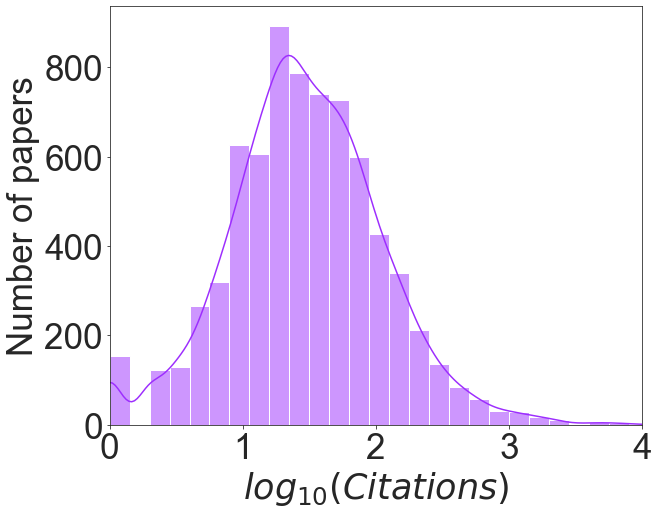

In [42]:
# Histograms number of citations for all year
# sns.set_style("darkgrid") # Set the graphical theme
sns.set_style("ticks")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)  # Set up a figure

sns.histplot(data=citation_data,
                x="log_citations",
                # color="#EE5007",
                color="#9D2EFE",
                kde=True,
                binwidth=0.15,
                ax=ax)

ax.set_xlabel("$log_{10}(Citations)$")
ax.set_ylabel("Number of papers")
ax.set_xlim(0, 4)

# fileName = 'citations_histogram_all_year'
# save_figure(path_figure_folder, fileName, fig)

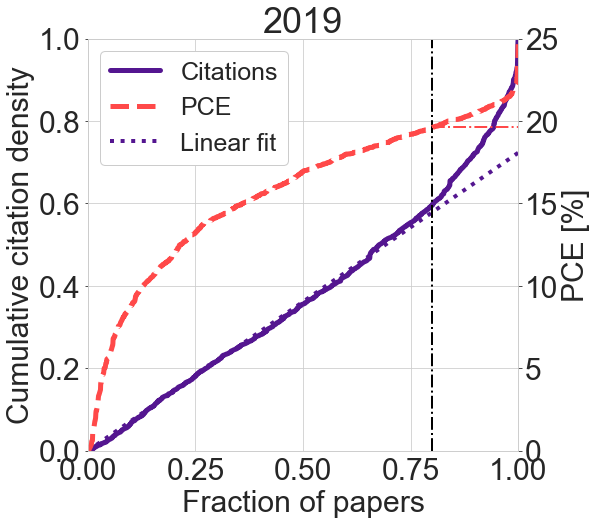

In [49]:
# Cumulative citations as a function of PCE
year = "2019"
cutoff = 0.8

data2 = citation_data[citation_data["date_bins_years"] == year]

data3 = data2.sort_values(by=["JV_default_PCE"])
data3["Citation_cumsum"] = data3["Citations"].cumsum()
data3["Citations_CDF"] = data3["Citation_cumsum"] / sum(data3["Citations"])
data3["paper_number"] = list(range(len(data3)))
data3["paper_number_norm"] = data3["paper_number"]/(max(data3["paper_number"]))

# Linear fit to citation data
data4 = data3[["paper_number_norm", "Citations_CDF", "JV_default_PCE"]][data3["paper_number_norm"] < cutoff]
x = data4["paper_number_norm"].values.reshape((-1, 1))
y = data4["Citations_CDF"].values
z = data4["JV_default_PCE"].values

model = LinearRegression(fit_intercept=False).fit(x, y)
data3["y_pred"] = model.predict(data3["paper_number_norm"].values.reshape(-1, 1))

# Set up figure
sns.set_style("whitegrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax1 = plt.subplots(figsize=(9, 8), tight_layout=True)  # Set up a figure
ax2 = ax1.twinx()

col1 = "#541690"
col2 = "#FF4949"

# Cumulative citations
line1 = ax1.plot(data3["paper_number_norm"], data3["Citations_CDF"],
                    lw=5,
                    color=col1,
                    label="Citations")

# PCE
line2 = ax2.plot(data3["paper_number_norm"], data3["JV_default_PCE"],
                    lw=5,
                    ls="--",
                    color=col2,
                    label="PCE")

# Linear fit to citation data
line3 = ax1.plot(data3["paper_number_norm"], data3["y_pred"],
                    lw=4,
                    color=col1,
                    ls=":",
                    label="Linear fit")

# Help lines
ax1.plot([cutoff, cutoff],[0, 1], lw=2, ls="-.", color="black")
ax2.plot([cutoff, 1], [z[-1], z[-1]], lw=2, ls="-.", color=col2)

# Legend
lns = line1+line2+line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, facecolor='white', framealpha=1, fontsize=25)

ax1.set_ylabel("Cumulative citation density")
ax2.set_ylabel("PCE [%]")
ax1.set_xlabel("Fraction of papers")
ax1.set_title(year)

ax1.set_ylim([0, 1])
ax2.set_ylim([0, 25])
ax1.set_xlim([0, 1.00])

ax2.grid(False)

# fileName = f'cumulative_citation_vs_pce_one_year_{year}'
# save_figure(path_figure_folder, fileName, fig)

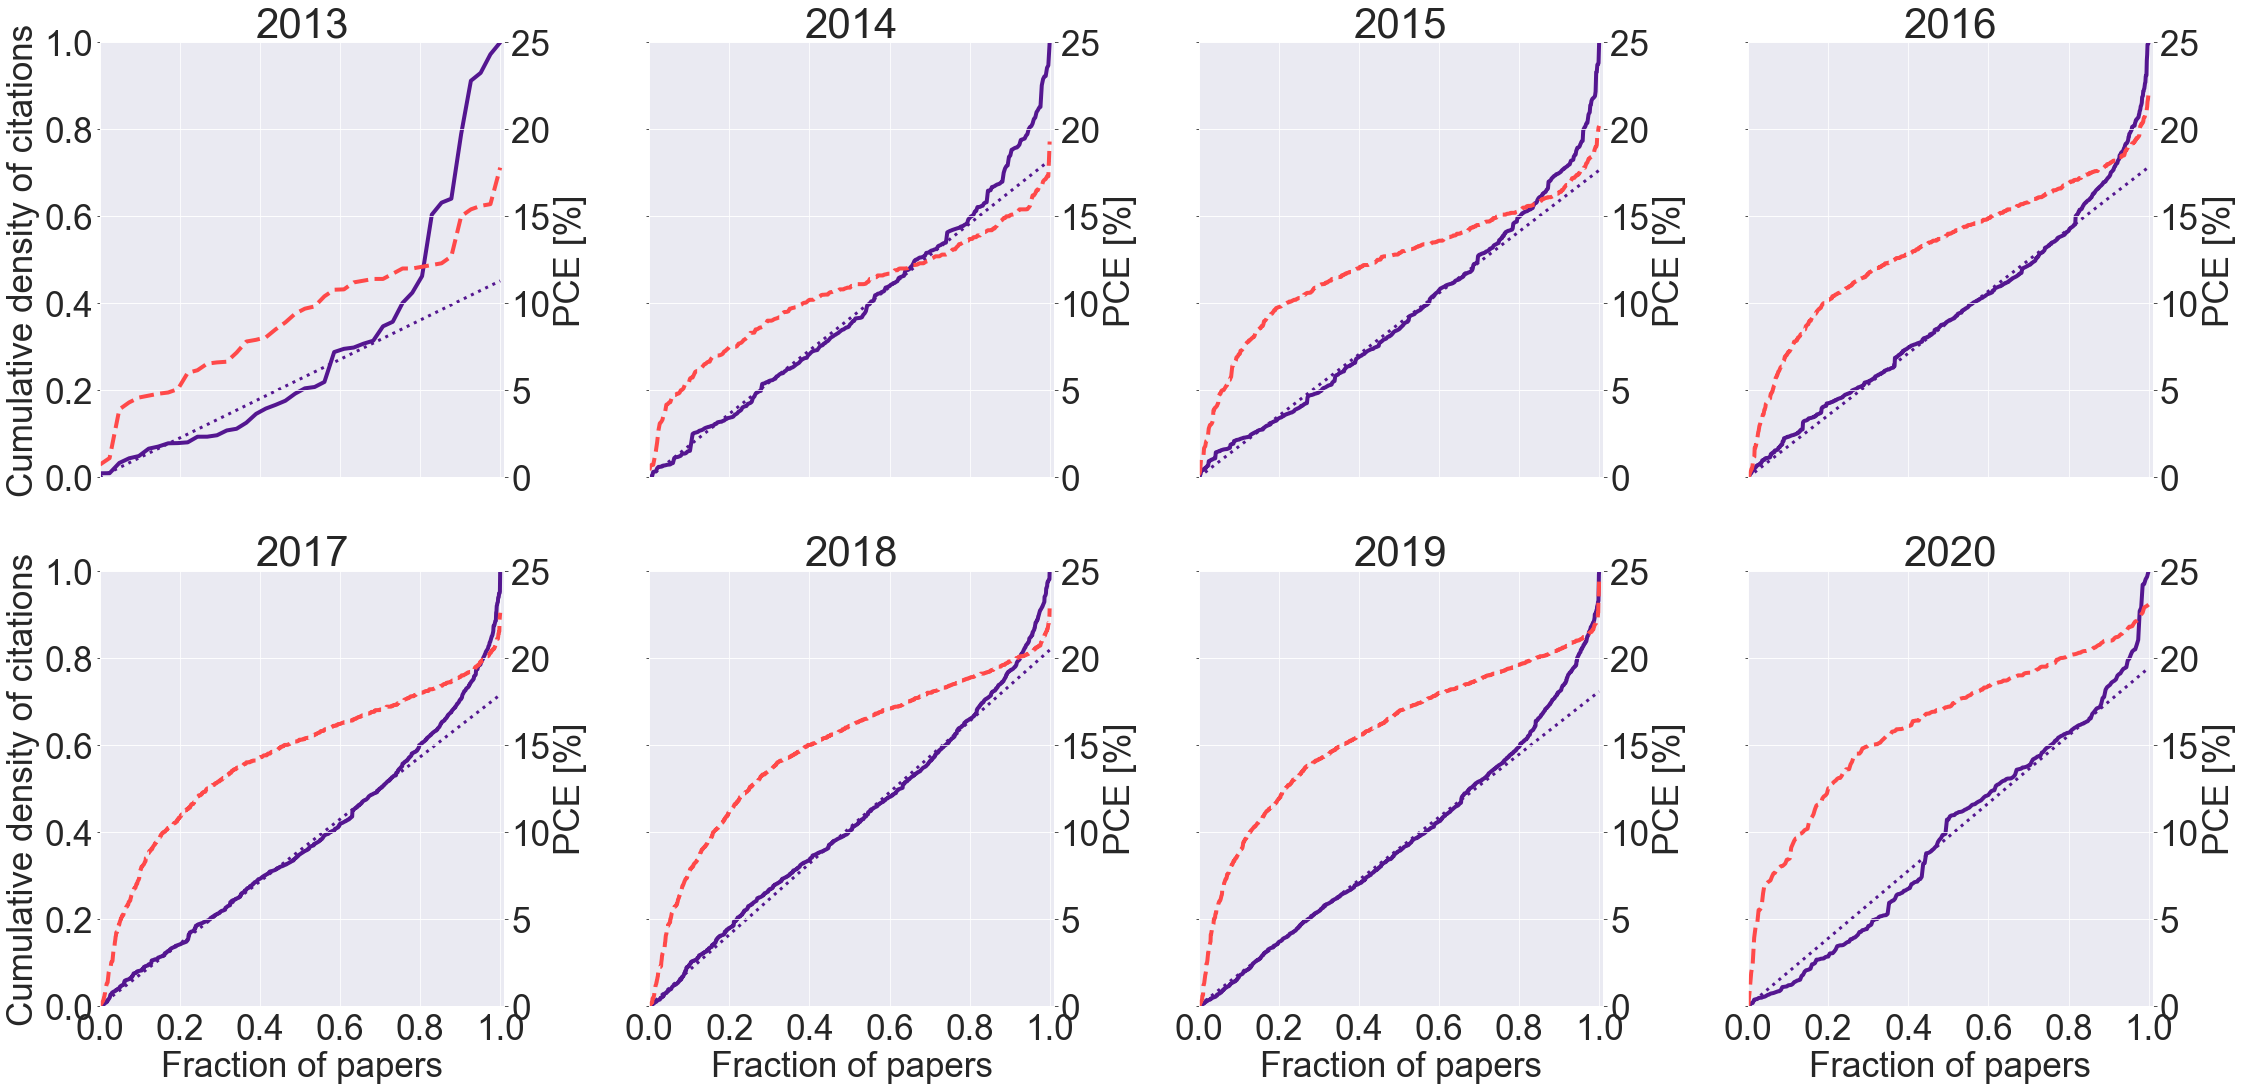

In [44]:
# Cumulative citations as a function of PCE all years
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

# Set up figure
sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat
axs2_flatten = [ax.twinx() for ax in axs_flatten]

col1 = "#541690"
col2 = "#FF4949"

for i, year in enumerate(years):
    data2 = citation_data[citation_data["date_bins_years"] == year]

    data3 = data2.sort_values(by=["JV_default_PCE"])
    data3["Citation_cumsum"] = data3["Citations"].cumsum()
    data3["Citations_CDF"] = data3["Citation_cumsum"] / sum(data3["Citations"])
    data3["paper_number"] = list(range(len(data3)))
    data3["paper_number_norm"] = data3["paper_number"] / (max(data3["paper_number"]))

    # Linear fit to citation data
    data4 = data3[["paper_number_norm", "Citations_CDF"]][data3["paper_number_norm"] < 0.8]
    x = data4["paper_number_norm"].values.reshape((-1, 1))
    y = data4["Citations_CDF"].values

    model = LinearRegression(fit_intercept=False).fit(x, y)
    data3["y_pred"] = model.predict(data3["paper_number_norm"].values.reshape(-1, 1))

    # ax1 = axs_flatten[i]
    # ax2 = ax1.twinx()

    # Cumulative citations
    line1 = sns.lineplot(data=data3, x="paper_number_norm", y="Citations_CDF",
                        lw=4,
                        color=col1,
                        # label="Citations",
                        ax=axs_flatten[i])

    # PCE
    line2 = sns.lineplot(data=data3, x="paper_number_norm", y="JV_default_PCE",
                        lw=4,
                        ls="--",
                        color=col2,
                        # label="PCE",
                        ax=axs2_flatten[i])

    # Linear fit to citation data
    line3 = sns.lineplot(data=data3, x="paper_number_norm", y="y_pred",
                        lw=3,
                        color=col1,
                        ls=":",
                        # label="Linear fit",
                        ax=axs_flatten[i])

    # lns = line1 + line2 + line3
    # labs = [l.get_label() for l in lns]
    # ax1.legend(lns, labs, loc=0)

    axs_flatten[i].set_ylabel("Cumulative density of citations")
    axs2_flatten[i].set_ylabel("PCE [%]")
    axs_flatten[i].set_xlabel("Fraction of papers")
    axs_flatten[i].set_title(year)

    axs_flatten[i].set_ylim([0, 1])
    axs2_flatten[i].set_ylim([0, 25])
    axs_flatten[i].set_xlim([0, 1.01])

    axs_flatten[i].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# fileName = 'cumulative_citation_vs_pce_all_year'
# save_figure(path_figure_folder, fileName, fig)

C:\Users\admin\AppData\Local\Temp\ipykernel_16304\2030006259.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=["2013", "", "2015", "", "2017", "", "2019", ""])


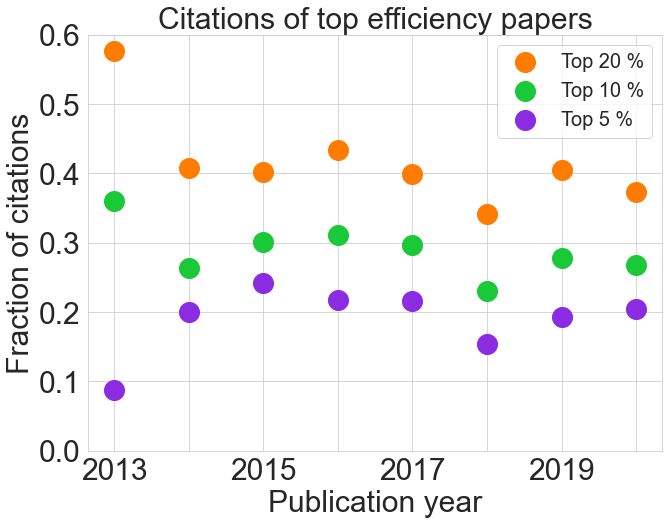

In [53]:
# winner takes it all plots
def get_cdf_estimate(data, years, cutoff):
    cdf = []
    pce = []

    for i, year in enumerate(years):
        data2 = data[data["date_bins_years"] == year]

        data3 = data2.sort_values(by=["JV_default_PCE"])
        data3["Citation_cumsum"] = data3["Citations"].cumsum()
        data3["Citations_CDF"] = data3["Citation_cumsum"] / sum(data3["Citations"])
        data3["paper_number"] = list(range(len(data3)))
        data3["paper_number_norm"] = data3["paper_number"] / (max(data3["paper_number"]))

        data4 = data3[["paper_number_norm", "Citations_CDF", "JV_default_PCE"]][data3["paper_number_norm"] < cutoff]
        x = data4["paper_number_norm"].values.reshape((-1, 1))
        y = data4["Citations_CDF"].values
        z = data4["JV_default_PCE"].values

        cdf.append(y[-1])
        pce.append(z[-1])

    return np.array(cdf), np.array(pce)

years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

cdf_80, pce_80 = get_cdf_estimate(citation_data, years, cutoff=0.8)
cdf_90, pce_90 = get_cdf_estimate(citation_data, years, cutoff=0.9)
cdf_95, pce_95 = get_cdf_estimate(citation_data, years, cutoff=0.95)

# Set up figure
# sns.set_style("darkgrid")  # Set the graphical theme
sns.set_style("whitegrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)  # Set up a figure

ax.scatter(years, 1 - cdf_80, s=400, color=sns.color_palette("bright")[1], label="Top 20 %")
ax.scatter(years, 1 - cdf_90, s=400, color=sns.color_palette("bright")[2], label="Top 10 %")
ax.scatter(years, 1 - cdf_95, s=400, color=sns.color_palette("bright")[4], label="Top 5 %")

ax.set_ylim(0, 0.6)

ax.set(xticklabels=["2013", "", "2015", "", "2017", "", "2019", ""])

ax.set_ylabel("Fraction of citations")
ax.set_xlabel("Publication year")
ax.set_title("Citations of top efficiency papers", fontsize=30)
ax.legend(fontsize=20)

# fileName = 'citations_cdf_years'
# save_figure(path_figure_folder, fileName, fig)

C:\Users\admin\AppData\Local\Temp\ipykernel_16304\4054109469.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=["2013", "", "2015", "", "2017", "", "2019", ""])


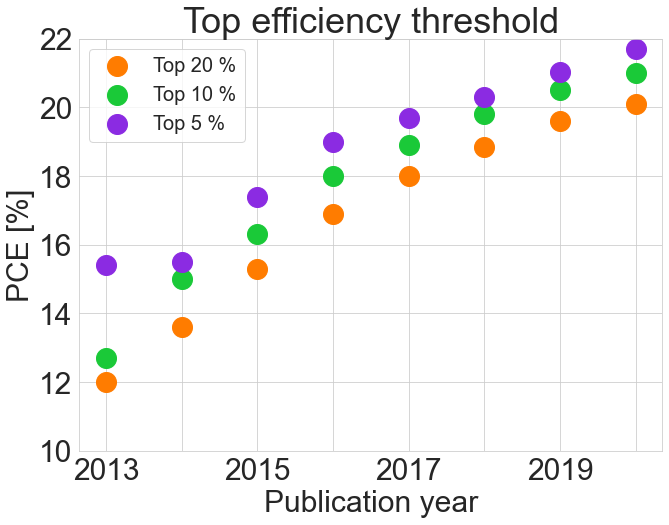

In [54]:
# Evolution of efficiency
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

cdf_80, pce_80 = get_cdf_estimate(citation_data, years, cutoff=0.8)
cdf_90, pce_90 = get_cdf_estimate(citation_data, years, cutoff=0.9)
cdf_95, pce_95 = get_cdf_estimate(citation_data, years, cutoff=0.95)

# Set up figure
sns.set_style("whitegrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)  # Set up a figure

ax.scatter(years, pce_80, s=400, color=sns.color_palette("bright")[1], label="Top 20 %")
ax.scatter(years, pce_90, s=400, color=sns.color_palette("bright")[2], label="Top 10 %")
ax.scatter(years, pce_95, s=400, color=sns.color_palette("bright")[4], label="Top 5 %")

ax.set_ylim(10, 22)

ax.set(xticklabels=["2013", "", "2015", "", "2017", "", "2019", ""])

ax.set_ylabel("PCE [%]")
ax.set_xlabel("Publication year")
ax.set_title("Top efficiency threshold")
ax.legend(fontsize=20)

# fileName = 'pce_cdf_years'
# save_figure(path_figure_folder, fileName, fig)

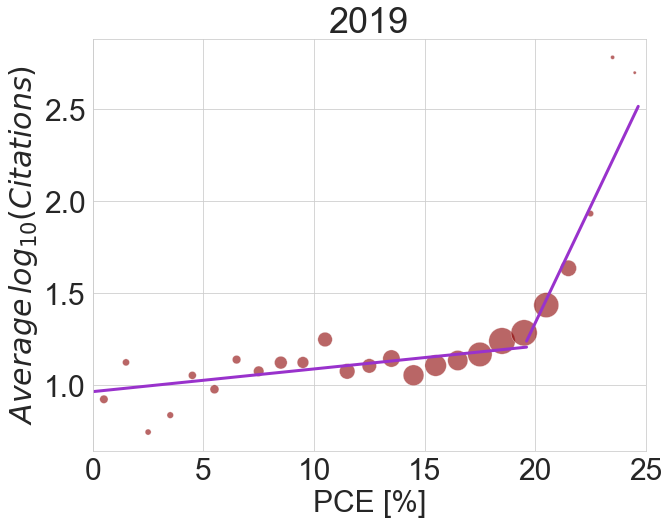

In [57]:
# Citations vs binned PCE bubble fit one year
year = "2019"
cutoff = 0.8

col1 = "#541690"
col2 = "#FF4949"

col1 = "darkred"
col2 = "darkorchid"

# Prepare data by binning with respect to PCE
data_year = citation_data[citation_data["date_bins_years"] == year]
cit_year_average = data_year.groupby(["PCE_bins"]).mean()["log_citations"].values
cit_year_median = data_year.groupby(["PCE_bins"]).median()["log_citations"].values
cit_year_counts = data_year.groupby(["PCE_bins"]).count()["log_citations"].values
PCE_bins = data_year.groupby(["PCE_bins"]).mean()["log_citations"].index.categories

data_binned = pd.DataFrame(list(zip(cit_year_average, cit_year_median, cit_year_counts, PCE_bins)),
                    columns=["average", "median", "counts", "PCE_bins"])

data_binned.dropna(inplace=True)

# Linear regression for region before and after cutoff
data_year = data_year.sort_values(by=["JV_default_PCE"], inplace=False)
data_year["paper_number"] = list(range(len(data_year)))
data_year["paper_number_norm"] = data_year["paper_number"] / (max(data_year["paper_number"]))

# Linear fit to citation data
data_pre_cutoff = data_year[["JV_default_PCE", "log_citations"]][data_year["paper_number_norm"] < cutoff]
x1 = data_pre_cutoff["JV_default_PCE"].values.reshape((-1, 1))
y1 = data_pre_cutoff["log_citations"].values

data_post_cutoff = data_year[["JV_default_PCE", "log_citations"]][data_year["paper_number_norm"] > cutoff]
x2 = data_post_cutoff["JV_default_PCE"].values.reshape((-1, 1))
y2 = data_post_cutoff["log_citations"].values

model1 = LinearRegression(fit_intercept=True).fit(x1, y1)
y_pred1 = model1.predict(x1)

model2 = LinearRegression(fit_intercept=True).fit(x2, y2)
y_pred2 = model2.predict(x2)

# Set up figure
sns.set_style("whitegrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)  # Set up a figure

# Bubble plot
sns.scatterplot(data=data_binned, x="PCE_bins", y="average",
                        size="counts",
                        sizes=(10, 700),
                        alpha=0.6,
                        color=col1,
                        legend=False,
                        ax=ax)

# Add linear fits
ax.plot(x1, y_pred1, lw=3, ls='-', color=col2)
ax.plot(x2, y_pred2, lw=3, ls='-', color=col2)

ax.set_xlim(0, 25)
ax.set_xlabel("PCE [%]")
ax.set_ylabel("$Average\/log_{10}(Citations)$")
ax.set_title(year)

# fileName = f'citations_vs_binned_pce_bubble_fit_one_year_{year}'
# save_figure(path_figure_folder, fileName, fig)

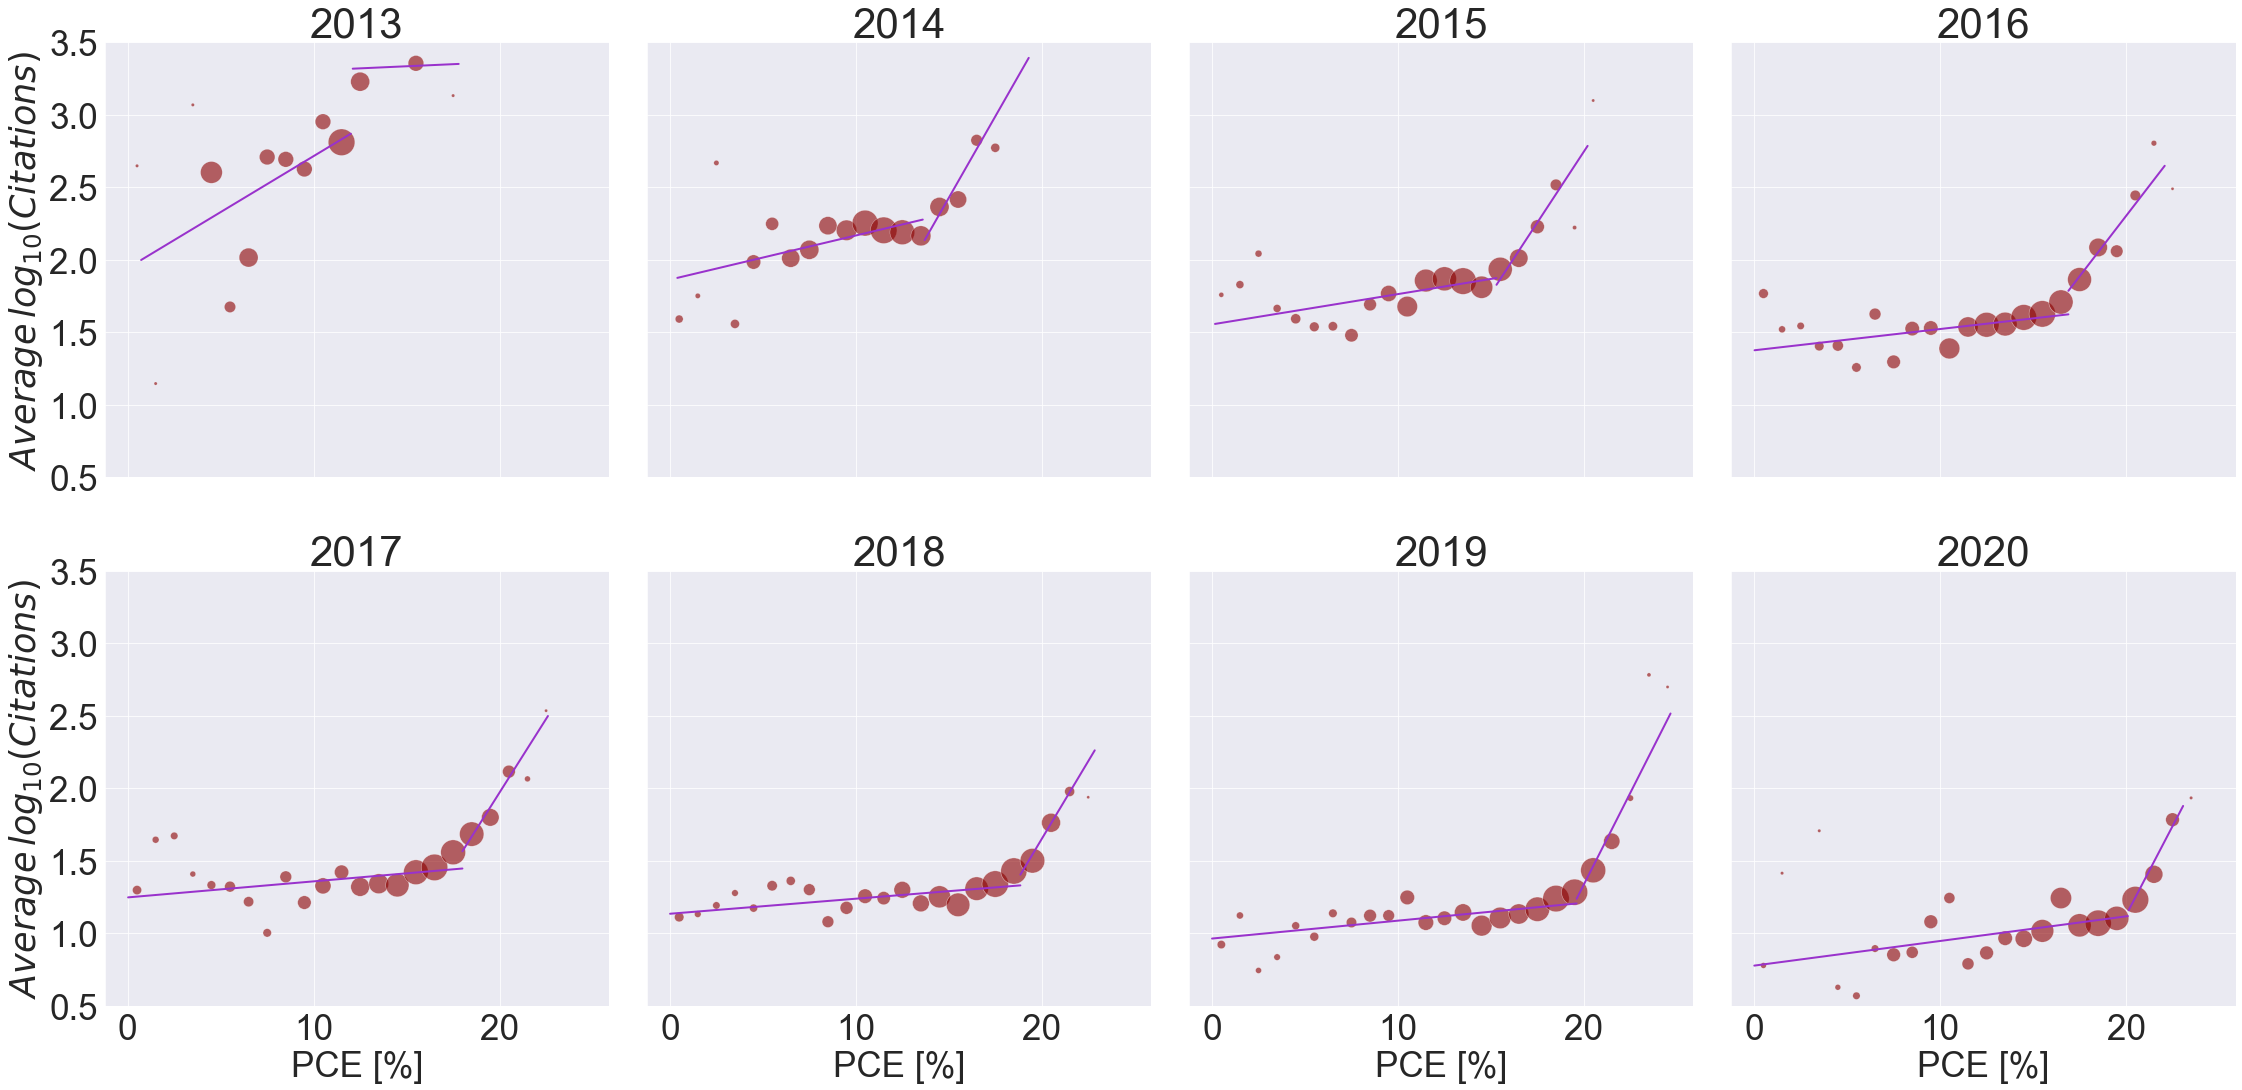

In [59]:
# Citations vs binned PCE bubble fit all years
cutoff = 0.8
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

col1 = "darkred"
col2 = "darkorchid"

# Set up figure
sns.set_style("darkgrid")  # Set the graphical theme
plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(2, 4, figsize=(8*4, 8*2), sharex=True, sharey=True, tight_layout=True)  # Set up a figure
axs_flatten = axs.flat

for i, year in enumerate(years):

    # Prepare data by binning with respect to PCE
    data_year = citation_data[citation_data["date_bins_years"] == year]
    cit_year_average = data_year.groupby(["PCE_bins"]).mean()["log_citations"].values
    cit_year_median = data_year.groupby(["PCE_bins"]).median()["log_citations"].values
    cit_year_counts = data_year.groupby(["PCE_bins"]).count()["log_citations"].values
    PCE_bins = data_year.groupby(["PCE_bins"]).mean()["log_citations"].index.categories

    data_binned = pd.DataFrame(list(zip(cit_year_average, cit_year_median, cit_year_counts, PCE_bins)),
                        columns=["average", "median", "counts", "PCE_bins"])

    data_binned.dropna(inplace=True)

    # Linear regression for region before and after cutoff
    data_year = data_year.sort_values(by=["JV_default_PCE"], inplace=False)
    data_year["paper_number"] = list(range(len(data_year)))
    data_year["paper_number_norm"] = data_year["paper_number"] / (max(data_year["paper_number"]))

    # Linear fit to citation data
    data_pre_cutoff = data_year[["JV_default_PCE", "log_citations"]][data_year["paper_number_norm"] < cutoff]
    x1 = data_pre_cutoff["JV_default_PCE"].values.reshape((-1, 1))
    y1 = data_pre_cutoff["log_citations"].values

    data_post_cutoff = data_year[["JV_default_PCE", "log_citations"]][data_year["paper_number_norm"] > cutoff]
    x2 = data_post_cutoff["JV_default_PCE"].values.reshape((-1, 1))
    y2 = data_post_cutoff["log_citations"].values

    model1 = LinearRegression(fit_intercept=True).fit(x1, y1)
    y_pred1 = model1.predict(x1)

    model2 = LinearRegression(fit_intercept=True).fit(x2, y2)
    y_pred2 = model2.predict(x2)

    # Bubble plot
    line = sns.scatterplot(data=data_binned, x="PCE_bins", y="average",
                            size="counts",
                            sizes=(10, 700),
                            alpha=0.6,
                            color=col1,
                            legend=False,
                            ax=axs_flatten[i])

    # Add linear fits
    axs_flatten[i].plot(x1, y_pred1, lw=2, ls='-', color=col2)
    axs_flatten[i].plot(x2, y_pred2, lw=2, ls='-', color=col2)

    axs_flatten[i].set_ylim(0.5, 3.5)

    axs_flatten[i].set_xlabel("PCE [%]")
    axs_flatten[i].set_ylabel("$Average\/log_{10}(Citations)$")
    axs_flatten[i].set_title(year)


# fileName = f'citations_vs_binned_pce_bubble_fit_all_years{year}'
# save_figure(path_figure_folder, fileName, fig)

In [61]:
def get_pce_binned_data_per_year(data, year):
    # Prepare data by binning with respect to PCE
    data_year = data[data["date_bins_years"] == year]
    cit_year_average = data_year.groupby(["PCE_bins"]).mean()["log_citations"].values
    cit_year_median = data_year.groupby(["PCE_bins"]).median()["log_citations"].values
    cit_year_counts = data_year.groupby(["PCE_bins"]).count()["log_citations"].values
    PCE_bins = data_year.groupby(["PCE_bins"]).mean()["log_citations"].index.categories

    data_binned = pd.DataFrame(list(zip(cit_year_average, cit_year_median, cit_year_counts, PCE_bins)),
                      columns=["average", "median", "counts", "PCE_bins"])

    data_binned.dropna(inplace=True)

    # Linear regression for region before and after cutoff
    data_year = data_year.sort_values(by=["JV_default_PCE"], inplace=False)
    data_year["paper_number"] = list(range(len(data_year)))
    data_year["paper_number_norm"] = data_year["paper_number"] / (max(data_year["paper_number"]))

    return data_year

In [63]:
# Generate and save liner fit metrics to a csv file
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]

intercepts_1 = []
intercepts_2 = []
sloop_1 = []
sloop_2 = []
sloop_1_non_log = []
sloop_2_non_log = []
cutoff_pce = []
MSE_1 = []
MSE_2 = []
RMSE_1 = []
RMSE_2 = []
MAE_1 = []
MAE_2 = []
r2_1 = []
r2_2 = []

# Linear models and associated metrics
for year in years:
    data_year = get_pce_binned_data_per_year(citation_data, year)

    data_pre_cutoff = data_year[["JV_default_PCE", "log_citations"]][data_year["paper_number_norm"] < cutoff]
    x1 = data_pre_cutoff["JV_default_PCE"].values.reshape((-1, 1))
    y1 = data_pre_cutoff["log_citations"].values

    data_post_cutoff = data_year[["JV_default_PCE", "log_citations"]][data_year["paper_number_norm"] > cutoff]
    x2 = data_post_cutoff["JV_default_PCE"].values.reshape((-1, 1))
    y2 = data_post_cutoff["log_citations"].values

    model1 = LinearRegression(fit_intercept=True).fit(x1, y1)
    y_pred1 = model1.predict(x1)

    model2 = LinearRegression(fit_intercept=True).fit(x2, y2)
    y_pred2 = model2.predict(x2)

    intercepts_1.append(model1.intercept_)
    intercepts_2.append(model2.intercept_)
    sloop_1.append(model1.coef_[0])
    sloop_2.append(model2.coef_[0])
    sloop_1_non_log.append(10**(model1.coef_[0]))
    sloop_2_non_log.append(10**(model2.coef_[0]))
    cutoff_pce.append(data_pre_cutoff["JV_default_PCE"].values[-1])
    MSE_1.append(metrics.mean_squared_error(y1, y_pred1))
    MSE_2.append(metrics.mean_squared_error(y2, y_pred2))
    RMSE_1.append(metrics.mean_squared_error(y1, y_pred1, squared=False))
    RMSE_2.append(metrics.mean_squared_error(y2, y_pred2, squared=False))
    MAE_1.append(metrics.mean_absolute_error(y1, y_pred1))
    MAE_2.append(metrics.mean_absolute_error(y2, y_pred2))
    r2_1.append(metrics.r2_score(y1, y_pred1))
    r2_2.append(metrics.r2_score(y2, y_pred2))

# Combine metrics to a pandas datafram
metrics_data = pd.DataFrame(list(zip(intercepts_1, sloop_1, sloop_1_non_log, MSE_1, RMSE_1, MAE_1, r2_1,
                                        cutoff_pce,
                                        intercepts_2, sloop_2, sloop_2_non_log, MSE_2, RMSE_2, MAE_2, r2_2,)),
                            columns=["Intercept_1", "Sloop_1", "Sloop_1_2", "MSE_1", "RMSE_1", "MEA_1", "r2_1",
                                    "cuttof_pce",
                                    "Intercept_2", "Sloop_2", "Sloop_2_2", "MSE_2", "RMSE_2", "MEA_2", "r2_2"],
                            index=years)

# metrics_data.round(3).to_csv("Linear fit metrics summary.csv")

metrics_data.round(3)

,Intercept_1,Sloop_1,Sloop_1_2,MSE_1,RMSE_1,MEA_1,r2_1,cuttof_pce,Intercept_2,Sloop_2,Sloop_2_2,MSE_2,RMSE_2,MEA_2,r2_2
2013,1.943,0.077,1.195,0.327,0.572,0.414,0.149,12.00,3.249,0.006,1.013,0.159,0.399,0.335,0.001
2014,1.863,0.030,1.073,0.198,0.445,0.337,0.040,13.60,-0.942,0.225,1.677,0.237,0.487,0.391,0.219
2015,1.554,0.021,1.049,0.233,0.483,0.356,0.021,15.30,-1.165,0.196,1.569,0.210,0.458,0.365,0.192
2016,1.376,0.015,1.034,0.244,0.494,0.369,0.013,16.90,-1.028,0.167,1.467,0.193,0.440,0.343,0.158
2017,1.248,0.011,1.026,0.236,0.485,0.371,0.009,18.00,-2.085,0.203,1.595,0.173,0.416,0.320,0.168
2018,1.135,0.010,1.024,0.257,0.507,0.392,0.009,18.85,-2.637,0.214,1.638,0.179,0.423,0.334,0.132
2019,0.964,0.012,1.029,0.206,0.454,0.357,0.015,19.61,-3.724,0.253,1.791,0.201,0.449,0.348,0.148
2020,0.777,0.017,1.040,0.220,0.469,0.371,0.025,20.10,-3.787,0.246,1.760,0.121,0.348,0.270,0.254


In [67]:
# Compute mean and median for the number of citations for each year
citation_median = []
citation_mean = []

date_labels_years = sorted(citation_data["date_bins_years"].unique().dropna())
for date_label in date_labels_years:
    temp = citation_data[citation_data["date_bins_years"] == date_label]
    citation_median.append(temp["Citations"].median())
    citation_mean.append(temp["Citations"].mean())

print(citation_median)    
print(citation_mean)

[2409.0, 1580.0, 562.0, 153.0, 74.0, 44.0, 31.0, 21.0, 17.0, 14.0, 120.0]
[2409.0, 3021.8, 1181.642857142857, 318.6764705882353, 148.54545454545453, 94.79464285714286, 60.08106169296987, 44.64916330063474, 31.036158192090394, 24.346863468634687, 244.8]
